In [36]:
import time

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

NUM_SAMPLES = 1000
device = 'cpu:0'

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [37]:
class SIRD(tf.keras.Model):
  
  def __init__(self, beta, gama, mi, **kwargs):
    super().__init__(**kwargs)
    
    self.beta, self.gama, self.mi = beta, gama, mi
  
  @tf.function
  def call(self, t, y):
    # y = [S, I, R, D]
    S, I, R, D = tf.unstack(y)
    
    dS_dt = - self.beta*I*S 
    dI_dt = self.beta*I*S - self.gama*I - self.mi*I
    dR_dt = self.gama*I
    dD_dt = self.mi*I
   
    
    return tf.stack([dS_dt, dI_dt, dR_dt, dD_dt])

In [38]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1e-4, 0, 0], dtype=tf.float64)

beta = 2.8
gama = 0.5
mi = 0.05

In [39]:
with tf.device(device):
  result = odeint(SIRD(beta, gama, mi), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 4)


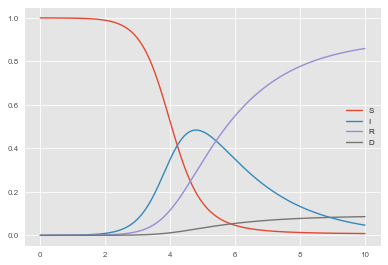

In [40]:
plot_results(t, result, labels=['S', 'I', 'R', 'D'])

In [41]:
class SIRDTrainable(tf.keras.Model):
  
  def __init__(self, beta, gama, mi, **kwargs):
    super().__init__(**kwargs)
    
    #Retire some parameters to allow training
    self.beta = beta
    self.gama = gama
    self.mi = mi
    
    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(4,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(4, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [S, I, R ,D]
    S, I, R, D = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 4]))  # [1, 4] -> [1, 4]
    
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    pred3 = n_out[0, 2]
    pred4 = n_out[0, 3]
    
    
    dS_dt = - self.beta*I*S + pred1 
    dI_dt = self.beta*I*S - self.gama*I - pred2 #pred2 = mi*I
    dR_dt = self.gama*I + pred3 #pred3 = gama*I 
    dD_dt = self.mi*I + pred4  #pred4 = gama*S
    
    return tf.stack([dS_dt, dI_dt, dR_dt, dD_dt])

In [42]:
t_train = tf.linspace(0., 10, num=50)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1e-4, 0, 0], dtype=tf.float64)

beta = 2.8
gama = 0.5
mi = 0.05

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [43]:
from tensorflow.keras import backend as K
K.clear_session()

In [44]:
start = time.time()
with tf.device(device):
  model = SIRDTrainable(beta, gama, mi)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(SIRD(beta, gama, mi), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train, atol = 1e-3)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()
end = time.time()
time_elapsed = end-start
print("Time elapsed: %f s" % time_elapsed)

Computing ground truth...
Ground truth shape : (50, 4)
Epoch 1
Loss : 0.0157648192398758
LR : 0.0099309245

Epoch 2
Loss : 0.0005335988508392042
LR : 0.009862327

Epoch 3
Loss : 0.0003609021437686671
LR : 0.009794203

Epoch 4
Loss : 0.00036400694567626597
LR : 0.0097265495

Epoch 5
Loss : 0.0003055926461736952
LR : 0.009659363

Epoch 6
Loss : 0.00037271482151523524
LR : 0.009592641

Epoch 7
Loss : 0.000358747319251865
LR : 0.009526379

Epoch 8
Loss : 0.00029026203243808396
LR : 0.009460577

Epoch 9
Loss : 0.0003364374513620075
LR : 0.009395227

Epoch 10
Loss : 0.00033399278971984363
LR : 0.0093303295

Epoch 11
Loss : 0.00028202970435342405
LR : 0.00926588

Epoch 12
Loss : 0.00030864974847274486
LR : 0.009201876

Epoch 13
Loss : 0.00031280062200911827
LR : 0.009138315

Epoch 14
Loss : 0.00028234341553906155
LR : 0.009075192

Epoch 15
Loss : 0.0002938521097889064
LR : 0.0090125045

Epoch 16
Loss : 0.00030474911238917765
LR : 0.00895025

Epoch 17
Loss : 0.0002925217839011381
LR : 0.008888

In [45]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [47]:
tolerance = 1e-4
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [48]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-4, rtol=1e-4)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss


In [49]:
start = time.time()
model = bfgs_optimizer.minimize(loss_wrapper, model)
end = time.time()
time_elapsed = end - start
print("Time Elapsed: %f" % time_elapsed)

Iter: 1 loss: 1.7860264016628545e-05
Iter: 2 loss: 1.7843000688712706e-05
Iter: 3 loss: 1.7836753226323971e-05
BFGS complete, and parameters updated !
Time Elapsed: 1.729434


In [50]:
t_eval = tf.linspace(0., 10, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(SIRD(beta, gama, mi), initial_states, t_eval)

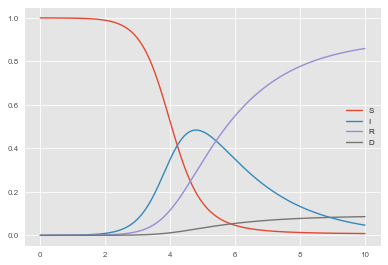

In [51]:
plot_results(t_eval, real_results, labels=['S', 'I', 'R', 'D'])

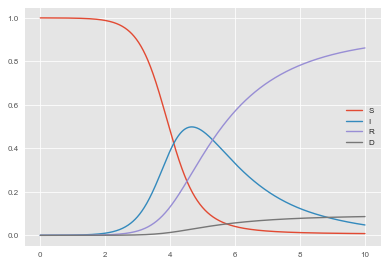

In [52]:
plot_results(t_eval, model_results, labels=['S', 'I', 'R', 'D'])

In [74]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [75]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

In [76]:
sindy_optm = SR3(threshold=0.1, nu=0.1, max_iter=500)
sindy_library = PolynomialLibrary(degree=20, include_interaction=True,  interaction_only=True)

In [77]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

C:\Users\ferna\Anaconda3\envs\tensorflow\lib\site-packages\pysindy\optimizers\sr3.py:269: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=20, interaction_only=True),
      feature_names=['x0', 'x1', 'x2', 'x3'],
      optimizer=SR3(max_iter=500, nu=0.1))

In [78]:
sindy_model.print()

x0' = -2.800 x0 x1 + 0.002 x0 x2 x3 + -0.015 x0 x1 x2 x3
x1' = -139.433 1 + 139.431 x0 + -42.068 x1 + 243.961 x2 + 24.396 x3 + 66.057 x0 x1 + 430.273 x0 x2 + 43.027 x0 x3 + 124.527 x1 x2 + 12.453 x1 x3 + -1154.515 x2 x3 + 57.792 x0 x1 x2 + 5.779 x0 x1 x3 + 14901.124 x0 x2 x3 + -950.939 x1 x2 x3 + -878.180 x0 x1 x2 x3
x2' = 0.500 x1 + 0.001 x0 x2 x3
x3' = 0.000


In [79]:
sindy_model.coefficients()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.79993024e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.30098354e-03,  0.00000000e+00,
        -1.47673649e-02],
       [-1.39433327e+02,  1.39431275e+02, -4.20682036e+01,
         2.43960700e+02,  2.43960705e+01,  6.60574894e+01,
         4.30272939e+02,  4.30272938e+01,  1.24527387e+02,
         1.24527382e+01, -1.15451467e+03,  5.77922813e+01,
         5.77922805e+00,  1.49011236e+04, -9.50939493e+02,
        -8.78180295e+02],
       [ 0.00000000e+00,  0.00000000e+00,  4.99995161e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.28932778e-04,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e

In [80]:
sindy_model.score(model_preds_np, t_eval_np)

0.4696796821262569